In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

## 1. Defining Functions:

### 1.1 Preprocessing Functions:

In [61]:
def calc_change_sentiment(data, col):
    change_in_sent = []
    change_in_sent.append(data[col][0])
    for i in range(1,len(data[col])):
        if data[col][i] == 0:
            change_in_sent.append(0)
        elif data[col][i] < 0 or data[col][i] > 0:
            dif = data[col][i] - data[col][(i-1)]
            change_in_sent.append(dif)
    return change_in_sent

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)       
    return input_txt
    
def clean_tweets(tweets):
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    tweets = np.vectorize(remove_pattern)(tweets, "b'")
    tweets = np.vectorize(remove_pattern)(tweets, 'b"')


    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets

In [62]:
def classify_news(dataframe, datetime_column_name):
    day22, day23, day24, day25, day26, day27, day28, day29, day30, day31, day32, day33, day34 = [],[],[],[],[],[],[],[],[],[],[],[],[]

    for i in range(len(dataframe[datetime_column_name])):
        if dataframe[datetime_column_name][i].day == 22 and (dataframe[datetime_column_name][i].hour <= 15 and dataframe[datetime_column_name][i].hour >= 9):
            day22.append(i)
        elif dataframe[datetime_column_name][i].day == 23 and (dataframe[datetime_column_name][i].hour <= 15 and dataframe[datetime_column_name][i].hour >= 9):
            day23.append(i)
        elif dataframe[datetime_column_name][i].day == 24 and (dataframe[datetime_column_name][i].hour <= 15 and dataframe[datetime_column_name][i].hour >= 9):
            day24.append(i)       
        elif dataframe[datetime_column_name][i].day == 25 and (dataframe[datetime_column_name][i].hour <= 15 and dataframe[datetime_column_name][i].hour >= 9):
            day25.append(i)
        elif dataframe[datetime_column_name][i].day == 26 and (dataframe[datetime_column_name][i].hour <= 15 and dataframe[datetime_column_name][i].hour >= 9):
            day26.append(i)
        elif dataframe[datetime_column_name][i].day == 27 and (dataframe[datetime_column_name][i].hour <= 15 and dataframe[datetime_column_name][i].hour >= 9):
            day27.append(i)
        elif dataframe[datetime_column_name][i].day == 28 and (dataframe[datetime_column_name][i].hour <= 15 and dataframe[datetime_column_name][i].hour >= 9):
            day28.append(i)
        elif dataframe[datetime_column_name][i].day == 29 and (dataframe[datetime_column_name][i].hour <= 15 and dataframe[datetime_column_name][i].hour >= 9):
            day29.append(i)
        elif dataframe[datetime_column_name][i].day == 30 and (dataframe[datetime_column_name][i].hour <= 15 and dataframe[datetime_column_name][i].hour >= 9):
            day30.append(i)
        elif dataframe[datetime_column_name][i].day == 1 and (dataframe[datetime_column_name][i].hour <= 15 and dataframe[datetime_column_name][i].hour >= 9):
            day31.append(i)
        elif dataframe[datetime_column_name][i].day == 2 and (dataframe[datetime_column_name][i].hour <= 15 and dataframe[datetime_column_name][i].hour >= 9):
            day32.append(i)
        elif dataframe[datetime_column_name][i].day == 3 and (dataframe[datetime_column_name][i].hour <= 15 and dataframe[datetime_column_name][i].hour >= 9):
            day33.append(i)
        elif dataframe[datetime_column_name][i].day == 4 and (dataframe[datetime_column_name][i].hour <= 15 and dataframe[datetime_column_name][i].hour >= 9):
            day34.append(i)
        else:
            pass
    news_d22, news_d23,news_d24,news_d25,news_d26,news_d27,news_d28,news_d29,news_d30,news_d31,news_d32,news_d33,news_d34 = dataframe.iloc[day22],dataframe.iloc[day23],dataframe.iloc[day24],dataframe.iloc[day25], dataframe.iloc[day26], dataframe.iloc[day27],dataframe.iloc[day28],dataframe.iloc[day29],dataframe.iloc[day30],dataframe.iloc[day31], dataframe.iloc[day32],dataframe.iloc[day33],dataframe.iloc[day34]
    return news_d22, news_d23,news_d24,news_d25,news_d26,news_d27,news_d28,news_d29,news_d30,news_d31,news_d32,news_d33,news_d34


In [63]:
def preprocess_headlines(data):
    data.drop_duplicates(subset='headline',keep=False, inplace=True)
    data.drop('ticker', axis=1, inplace=True)
    data.set_index('date_time', inplace=True)
    data_30m = data.resample('30min').median().ffill().reset_index()
    compound_sma = data_30m['compound'].rolling(window=3).mean()
    data_30m['Compound SMA(3) Headlines'] = compound_sma
    change_in_sent=calc_change_sentiment(data_30m, 'compound')
    data_30m['change in sentiment headlines'] = change_in_sent
    data_30m['change in sentiment headlines (t-1)'] = data_30m['change in sentiment headlines'].shift(1)
    # Splitting the headlines into days.
    news_d22, news_d23,news_d24,news_d25,news_d26,news_d27,news_d28,news_d29,news_d30,news_d31,news_d32,news_d33,news_d34 = classify_news(data_30m, 'date_time')
    # Removing the first row because the time is 9:00am, which will not align with the stock data, which starts at 9:30am.
    news_d23_red,news_d24_red,news_d25_red,news_d26_red,news_d27_red,news_d28_red,news_d29_red,news_d30_red,news_d31_red,news_d32_red,news_d33_red,news_d34_red = news_d23.iloc[4:],news_d24.iloc[1:],news_d25.iloc[1:],news_d26.iloc[1:],news_d27.iloc[1:],news_d28.iloc[1:],news_d29.iloc[1:],news_d30.iloc[1:],news_d31.iloc[1:],news_d32.iloc[1:],news_d33.iloc[1:],news_d34.iloc[1:]
    # Merge the days.
    frames_news = [news_d23_red,news_d24_red, news_d25_red, news_d28_red,news_d29_red,news_d30_red,news_d31_red,news_d32_red,news_d33_red,news_d34_red]
    processed_headlines = pd.concat(frames_news)
    return processed_headlines
    

In [64]:
def preprocess_posts(dataframe):
    vader = SentimentIntensityAnalyzer()
    dataframe['tweet_text'] = clean_tweets(dataframe['tweet_text'])
    scores = dataframe['tweet_text'].apply(vader.polarity_scores).tolist()
    scores_df = pd.DataFrame(scores)

    df = dataframe.join(scores_df, rsuffix='_right')
    df = df[['timestamp','tweet_text','followers_count','neg','neu','pos','compound']]
    df['timestamp'] = df['timestamp'].dt.tz_localize('UTC').dt.tz_convert('America/Montreal').dt.tz_localize(None)
    df['scaled_followers_count'] =(df['followers_count']/df['followers_count'].max()) + 1
    df['adj compound'] = df['compound']*df['scaled_followers_count']
    df.set_index('timestamp', inplace=True)

    twitter_df_30m = df.resample('30min').median().ffill().reset_index()
    compound_sma = twitter_df_30m['compound'].rolling(window=3).mean()
    twitter_df_30m['Compound SMA(3) Twitter'] = compound_sma
    change_in_sent = calc_change_sentiment(twitter_df_30m, 'adj compound')
    twitter_df_30m['change in sentiment twitter'] = change_in_sent
    twitter_df_30m['change in sentiment twitter (t-1)'] = twitter_df_30m['change in sentiment twitter'].shift(1)

    tw_news_d22,tw_news_d23,tw_news_d24,tw_news_d25,tw_news_d26,tw_news_d27,tw_news_d28,tw_news_d29,tw_news_d30,tw_news_d31,tw_news_d32,tw_news_d33,tw_news_d34 = classify_news(twitter_df_30m, 'timestamp')

    tw_news_d23_30m,tw_news_d24_30m,tw_news_d25_30m, tw_news_d26_30m,tw_news_d27_30m,tw_news_d28_30m,tw_news_d29_30m,tw_news_d30_30m,tw_news_d31_30m,tw_news_d32_30m,tw_news_d33_30m,tw_news_d34_30m = tw_news_d23.iloc[4:],tw_news_d24.iloc[1:],tw_news_d25.iloc[1:],tw_news_d26.iloc[1:],tw_news_d27.iloc[1:],tw_news_d28.iloc[1:],tw_news_d29.iloc[1:],tw_news_d30.iloc[1:],tw_news_d31.iloc[1:],tw_news_d32.iloc[1:],tw_news_d33.iloc[1:],tw_news_d34.iloc[1:]

    frames = [tw_news_d23_30m,tw_news_d24_30m,tw_news_d25_30m, tw_news_d28_30m,tw_news_d29_30m,tw_news_d30_30m,tw_news_d31_30m,tw_news_d32_30m,tw_news_d33_30m,tw_news_d34_30m]
    processed_tweets = pd.concat(frames)
    return processed_tweets

### 1.2 Modeling Functions:

In [65]:
def baseline_model(data):
    # data_SMA = data['Adj Close'].rolling(window=3).mean().shift(1)
    # data['SMA(3)'] = data_SMA
    pred = data['SMA(3)'][3:]
    actu = data['Adj Close'][3:]
    rmse = np.sqrt(mean_squared_error(actu,pred))
    r2_sco = r2_score(actu,pred)
    # print('Root Mean Squared Error: ',rmse)
    # print('R2 Score: ', r2_sco)
    return rmse, r2_sco

In [85]:
def linear_modeling_no_sentiment(dataframe):
    x_var = ['Adj Close','Scaled Volume','Scaled Delta Close','SMA(3)']
    i = len(dataframe['t+1'])-4
    y_train, y_test = dataframe['t+1'][3:i], dataframe['t+1'][i:-1]
    X_train, X_test = dataframe[x_var][3:i], dataframe[x_var][i:-1]

    lm = LinearRegression()
    lm.fit(X_train,y_train)
    predictions = lm.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test,predictions))
    r2_sco = r2_score(y_test,predictions)
    # print('LR Root Mean Squared Error: ',rmse)
    # print('LR R2 Score: ', r2_sco, '\n')
    
    reg = SGDRegressor(random_state=42)
    reg.fit(X_train, y_train)
    predictions2 = reg.predict(X_test)
    rmse2 = np.sqrt(mean_squared_error(y_test,predictions2))
    r2_sco2 = r2_score(y_test,predictions2)
    # print('SGD Root Mean Squared Error: ',rmse2)
    # print('SGD R2 Score: ', r2_sco2)
    return rmse,r2_sco,rmse2,r2_sco2

In [86]:
def linear_modeling_headlines(dataframe):
    x_var = ['Adj Close','Scaled Volume','Scaled Delta Close','compound','Compound SMA(3) Headlines','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)']
    i = len(dataframe['t+1'])-4
    y_train, y_test = dataframe['t+1'][:i], dataframe['t+1'][i:-1]
    X_train, X_test = dataframe[x_var][:i], dataframe[x_var][i:-1]

    lm = LinearRegression()
    lm.fit(X_train,y_train)
    predictions = lm.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,predictions))
    r2_sco = r2_score(y_test,predictions)
    # print('LR Root Mean Squared Error: ',rmse)
    # print('LR R2 Score: ', r2_sco,'\n')
    
    reg = SGDRegressor(random_state=42)
    reg.fit(X_train, y_train)
    predictions2 = reg.predict(X_test)
    rmse2 = np.sqrt(mean_squared_error(y_test,predictions2))
    r2_sco2 = r2_score(y_test,predictions2)
    # print('SGD Root Mean Squared Error: ',rmse2)
    # print('SGD R2 Score: ', r2_sco2)

    xg_reg = xgb.XGBRegressor(booster='gblinear', learning_rate = 0.03, n_estimators = 10000)
    xg_reg.fit(X_train,y_train)
    preds3 = xg_reg.predict(X_test)
    rmse3 = np.sqrt(mean_squared_error(y_test, preds3))
    r2_sco3 = r2_score(y_test,preds3)

    svr = SVR(kernel='linear')
    svr.fit(X_train,y_train)
    preds4 = svr.predict(X_test)
    rmse4 = np.sqrt(mean_squared_error(y_test,preds4))
    r2_sco4 = r2_score(y_test,preds4)

    return rmse,r2_sco,rmse2,r2_sco2,rmse3,r2_sco3,rmse4,r2_sco4

In [87]:
def linear_model_twitter(dataframe):
    x_var = ['Adj Close','Scaled Volume','Scaled Delta Close','compound','Compound SMA(3) Twitter','SMA(3)','change in sentiment twitter','change in sentiment twitter (t-1)']
    i = len(dataframe['t+1'])-4
    y_train, y_test = dataframe['t+1'][:i], dataframe['t+1'][i:-1]
    X_train, X_test = dataframe[x_var][:i], dataframe[x_var][i:-1]

    lm = LinearRegression()
    lm.fit(X_train,y_train)
    predictions = lm.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,predictions))
    r2_sco = r2_score(y_test,predictions)
    # print('LR Root Mean Squared Error: ',rmse)
    # print('LR R2 Score: ', r2_sco,'\n')

    reg = SGDRegressor(random_state=42)
    reg.fit(X_train, y_train)
    predictions2 = reg.predict(X_test)
    rmse2 = np.sqrt(mean_squared_error(y_test,predictions2))
    r2_sco2 = r2_score(y_test,predictions2)
    # print('SGD Root Mean Squared Error: ',rmse2)
    # print('SGD R2 Score: ', r2_sco2)

    xg_reg = xgb.XGBRegressor(booster='gblinear', learning_rate = 0.03, n_estimators = 10000)
    xg_reg.fit(X_train,y_train)
    preds3 = xg_reg.predict(X_test)
    rmse3 = np.sqrt(mean_squared_error(y_test, preds3))
    r2_sco3 = r2_score(y_test,preds3)

    svr = SVR(kernel='linear')
    svr.fit(X_train,y_train)
    preds4 = svr.predict(X_test)
    rmse4 = np.sqrt(mean_squared_error(y_test,preds4))
    r2_sco4 = r2_score(y_test,preds4)

    return rmse,r2_sco,rmse2,r2_sco2,rmse3,r2_sco3,rmse4,r2_sco4

In [88]:
def multi_model_full(dataframe):
    x_var = ['Adj Close','Scaled Volume','Scaled Delta Close','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']
    i = len(dataframe['t+1'])-4
    y_train, y_test = dataframe['t+1'][:i], dataframe['t+1'][i:-1]
    X_train, X_test = dataframe[x_var][:i], dataframe[x_var][i:-1]

    lm = LinearRegression()
    lm.fit(X_train,y_train)
    predictions = lm.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,predictions))
    r2_sco = r2_score(y_test,predictions)
    #print('LR Root Mean Squared Error: ',rmse)
    #print('LR R2 Score: ', r2_sco,'\n')

    reg = SGDRegressor(random_state=42)
    reg.fit(X_train, y_train)
    predictions2 = reg.predict(X_test)
    rmse2 = np.sqrt(mean_squared_error(y_test,predictions2))
    r2_sco2 = r2_score(y_test,predictions2)
    #print('SGD Root Mean Squared Error: ',rmse2)
    #print('SGD R2 Score: ', r2_sco2,'\n')

    xg_reg = xgb.XGBRegressor(booster='gblinear', learning_rate = 0.03, n_estimators = 10000)
    xg_reg.fit(X_train,y_train)
    preds3 = xg_reg.predict(X_test)
    rmse3 = np.sqrt(mean_squared_error(y_test, preds3))
    r2_sco3 = r2_score(y_test,preds3)
    #print('XGB Mean Squared Error: ',rmse3)
    #print('XGB R2 Score: ', r2_sco3)

    rf_regr = RandomForestRegressor(n_estimators=20, max_depth=600, random_state=42)
    rf_regr.fit(X_train,y_train)
    preds4 = rf_regr.predict(X_test)
    rmse4 = np.sqrt(mean_squared_error(y_test, preds4))
    r2_sco4 = r2_score(y_test,preds4)

    svr = SVR(kernel='linear')
    svr.fit(X_train,y_train)
    preds5 = svr.predict(X_test)
    rmse5 = np.sqrt(mean_squared_error(y_test,preds5))
    r2_sco5 = r2_score(y_test,preds5)

    return rmse,r2_sco,rmse2,r2_sco2,rmse3,r2_sco3,rmse4,r2_sco4,rmse5,r2_sco5

## 2. Evaluate Model with Individual Stocks:

In [114]:
def import_data(ticker):    
    # 1. Historical Stock Data:
    stock_df = pd.read_csv('~/LighthouseLabs-Final/1. Stock_Data/'+ticker+'_data.csv', index_col=0, parse_dates=['Datetime'])
    # 2. Headline Data:
    headlines1 = pd.read_csv('~/LighthouseLabs-Final/2. FinViz_Headline_Data/'+ticker+'_2020-09-23_2020-10-01.csv', index_col=0, parse_dates=['date_time'])
    # headlines2 = pd.read_csv('~/LighthouseLabs-Final/2. FinViz_Headline_Data/'+ticker+'_data_2020-10-01-23-02.csv', index_col=0, parse_dates=[['date','time']])
    frames = [headlines1]
    headlines_df = pd.concat(frames)
    headlines_df.drop_duplicates(subset='headline',keep='first',inplace=True)
    # headlines_df.to_csv('~/LighthouseLabs-Final/2. FinViz_Headline_Data/'+ticker+'_2020-09-23_2020-10-01.csv')

    # 3. Twitter Data:
    twitter1 = pd.read_csv('~/LighthouseLabs-Final/3. Twitter_Data/'+ticker+'_2020-09-23_2020-10-01.csv', index_col=0, parse_dates=['timestamp'])
    # twitter2 = pd.read_csv('~/LighthouseLabs-Final/3. Twitter_Data/'+ticker+'_2020-10-01.csv', parse_dates=['timestamp'])
    # twitter3 = pd.read_csv('~/LighthouseLabs-Final/3. Twitter_Data/'+ticker+'_2020-10-01_2.csv', parse_dates=['timestamp'])
    frames = [twitter1]
    twitter_df = pd.concat(frames)
    twitter_df.drop_duplicates(subset='tweet_text',keep='first', inplace=True)
    # twitter_df.to_csv('~/LighthouseLabs-Final/3. Twitter_Data/'+ticker+'_2020-09-23_2020-10-01.csv')

    return stock_df,headlines_df,twitter_df

In [71]:
def evaluate_models(baseline_df, headline_df, twitter_df):
    #1. Baseline:
    baseline_rmse, baseline_r2 = baseline_model(baseline_df)
    baseline_df2 = baseline_df
    baseline_df2['t+1'] = baseline_df2['Adj Close'].shift(-1)
    lm_baseline_rmse, lm_baseline_r2, sgd_baseline_rmse, sgd_baseline_r2 = linear_modeling_no_sentiment(baseline_df2)
    #2. Headline Final Merge:
    headlines_final = preprocess_headlines(headline_df)
    with_headlines_df = stock_df.merge(headlines_final, left_on='Datetime', right_on='date_time').drop('date_time',axis=1)
    with_headlines_df['t+1'] = with_headlines_df['Adj Close'].shift(-1)
    #3. Twitter Final Merge:
    final_twitter = preprocess_posts(twitter_df)
    with_twitter_df = stock_df.merge(final_twitter, left_on='Datetime', right_on='timestamp').drop('timestamp',axis=1)
    with_twitter_df['t+1'] = with_twitter_df['Adj Close'].shift(-1)
    #4. Full Merge:
    full_df = with_twitter_df.merge(headlines_final, left_on='Datetime', right_on='date_time').drop('date_time',axis=1)
    full_df['t+1'] = full_df['Adj Close'].shift(-1)
    #5. Evaluating Models:
    lm_headlines_rmse, lm_headlines_r2, sgd_headlines_rmse, sgd_headlines_r2,xgb_headlines_rmse,xgb_headlines_r2,svr_headlines_rmse,svr_headlines_r2 = linear_modeling_headlines(with_headlines_df)
    lm_twitter_rmse, lm_twitter_r2, sgd_twitter_rmse, sgd_twitter_r2,xgb_twitter_rmse,xgb_twitter_r2,svr_twitter_rmse,svr_twitter_r2 = linear_model_twitter(with_twitter_df)
    lm_all_rmse, lm_all_r2, sgd_all_rmse, sgd_all_r2, xgb_all_rmse, xgb_all_r2, rf_all_rmse, rf_all_r2,svr_all_rmse,svr_all_r2 = multi_model_full(full_df)
    #6. Store in dict:
    result_dict = {
    'RMSE - Baseline':baseline_rmse, 'R2 - Baseline':baseline_r2, 'Linear RMSE - Baseline':lm_baseline_rmse, 'Linear R2 - Baseline':lm_baseline_r2, 'SGD RMSE - Baseline':sgd_baseline_rmse, 'SGD R2 - Baseline':sgd_baseline_r2,
    'Linear RMSE - Only Headlines': lm_headlines_rmse, 'Linear R2 - Only Headlines':lm_headlines_r2, 'SGD RMSE - Only Headlines':sgd_headlines_rmse, 'SGD R2 - Only Headlines':sgd_headlines_r2, 'XGB RMSE - Only Headlines':xgb_headlines_rmse, 'XGB R2 - Only Headlines':xgb_headlines_r2, 'SVR RMSE - Only Headlines':svr_headlines_rmse, 'SVR R2 - Only Headlines': svr_headlines_r2,
    'Linear RMSE - Only Twitter':lm_twitter_rmse, 'Linear R2 - Only Twitter':lm_twitter_r2, 'SGD RMSE - Only Twitter':sgd_twitter_rmse, 'SGD R2 - Only Twitter':sgd_twitter_r2, 'XGB RMSE - Only Twitter':xgb_twitter_rmse, 'XGB R2 - Only Twitter':xgb_twitter_r2,'SVR RMSE - Only Twitter':svr_twitter_rmse,'SVR R2 - Only Twitter':svr_twitter_r2,
    'Linear RMSE - All':lm_all_rmse, 'Linear R2 - All':lm_all_r2, 'SGD RMSE - All':sgd_all_rmse, 'SGD R2 - All':sgd_all_r2, 'XGB RMSE - All':xgb_all_rmse, 'XGB R2 - All':xgb_all_r2, 'RF RMSE - All':rf_all_rmse,'RF R2 - All':rf_all_r2,'SVR RMSE - All':svr_all_rmse,'SVR R2 - All':svr_all_r2
    }
    #7. Convert to DataFrame:
    result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['Values'])
    #result_df.to_csv('~/LighthouseLabs-Final/Report_Analysis/AAPL_complete_analysis.csv')
    return result_df, full_df

In [152]:
stock_df, headlines_df, twitter_df = import_data('FB')
result_df, full_df = evaluate_models(stock_df, headlines_df, twitter_df)
result_df

,Values
RMSE - Baseline,1.322978e+00
R2 - Baseline,9.531775e-01
Linear RMSE - Baseline,8.517884e-01
Linear R2 - Baseline,-1.305581e+00
SGD RMSE - Baseline,1.123277e+13
SGD R2 - Baseline,-4.009503e+26
Linear RMSE - Only Headlines,1.708423e-01
Linear R2 - Only Headlines,-1.059878e+01
SGD RMSE - Only Headlines,1.396518e+14
SGD R2 - Only Headlines,-7.750230e+30


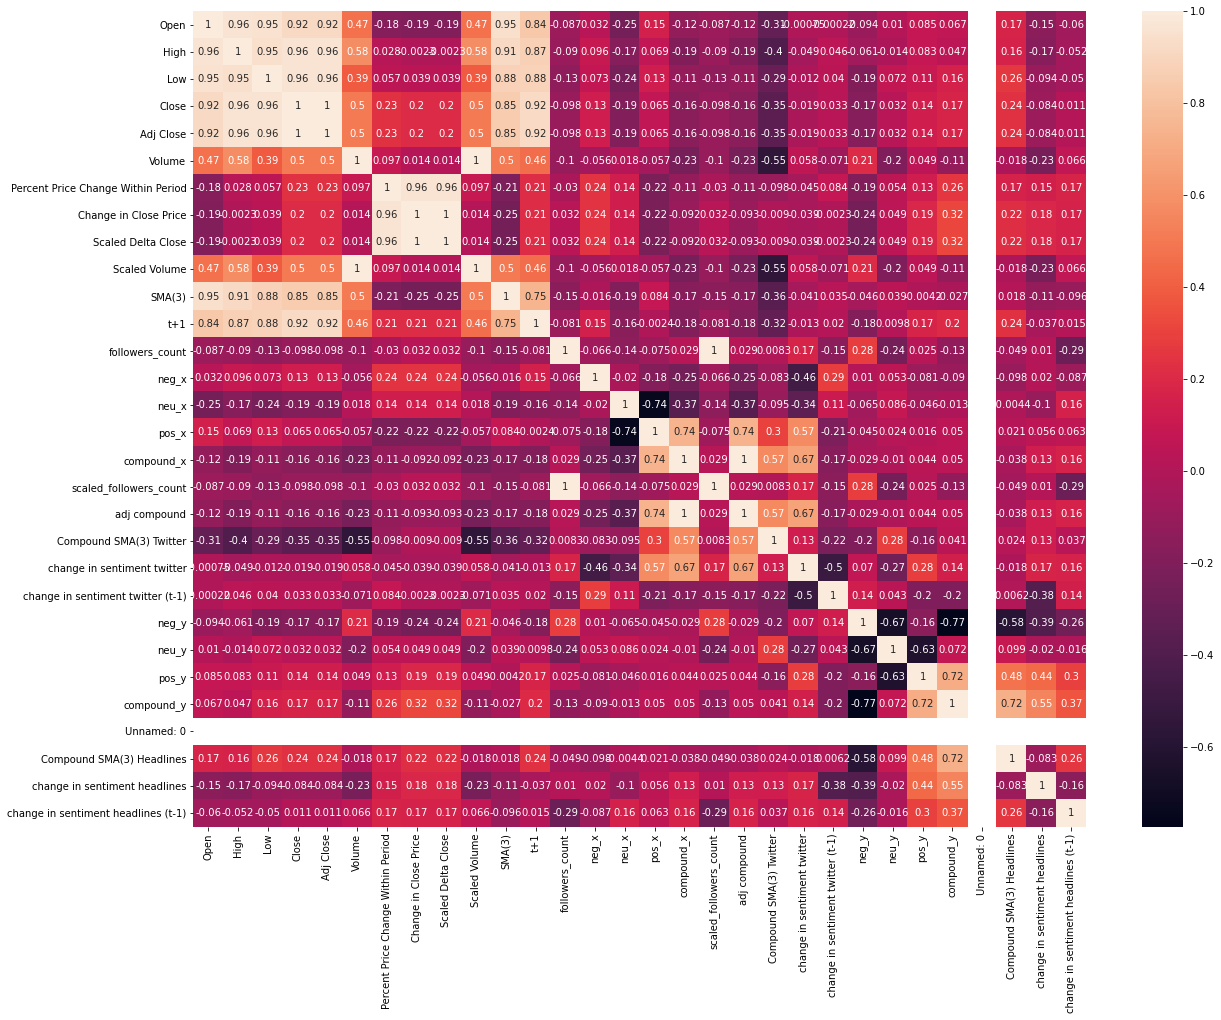

In [144]:
import seaborn as sn
from matplotlib.pyplot import figure
corrMatrix = full_df.corr()
plt.figure(figsize=(20,15))
sn.heatmap(corrMatrix, annot=True)

plt.show()

In [153]:
i = round(len(full_df['t+1'])*0.8)
y_train, y_test = full_df['t+1'][:i], full_df['t+1'][i:-1]
X_train, X_test = full_df[['Adj Close','Scaled Volume','Scaled Delta Close','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']][:i], full_df[['Adj Close','Scaled Volume','Scaled Delta Close','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']][i:-1]

X_predic = full_df[['Adj Close','Scaled Volume','Scaled Delta Close','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']][:-1]

svr =SVR(kernel='linear')
svr.fit(X_train,y_train)
preds5 = svr.predict(X_predic)
preds5 = np.append(preds5,np.NaN)
full_df['price predictions svr'] = preds5

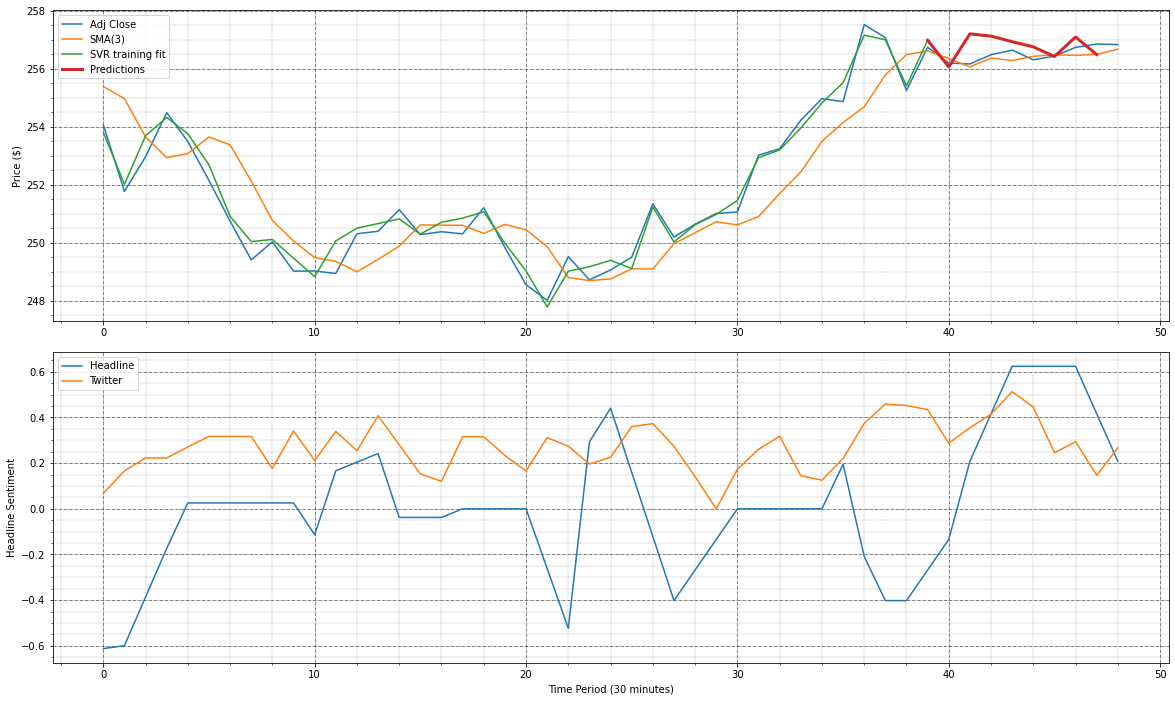

In [154]:
fig = plt.figure(figsize=(20,12))
# The price subplot:
price_ax = plt.subplot(2,1,1)
price_ax.plot(full_df.index, full_df['Adj Close'], label='Adj Close')
price_ax.plot(full_df.index, full_df['SMA(3)'], label='SMA(3)')
price_ax.plot(full_df.index[:-1], full_df['price predictions svr'][:-1], label='SVR training fit')
price_ax.plot(full_df.index[i:-1], full_df['price predictions svr'][i:-1], label='Predictions',linewidth=3)
price_ax.set_ylabel('Price ($)')
price_ax.grid(which='major', color='k', linestyle='-.', linewidth=0.5)
price_ax.minorticks_on()
price_ax.grid(which='minor', color='k', linestyle=':', linewidth=0.3)
price_ax.legend()
# The ROC subplot shares the date axis with the price plot:
roc_ax = plt.subplot(2,1,2, sharex=price_ax)
roc_ax.plot(full_df.index, full_df['Compound SMA(3) Headlines'],label='Headline')
roc_ax.plot(full_df.index, full_df['Compound SMA(3) Twitter'],label='Twitter')
roc_ax.set_xlabel('Time Period (30 minutes)')
roc_ax.set_ylabel('Headline Sentiment')
roc_ax.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
roc_ax.minorticks_on()
roc_ax.grid(which='minor', color='k', linestyle=':', linewidth=0.3)
roc_ax.legend()
# We can add titles to each of the subplots:
# price_ax.set_title("Apple Stock - Moving Averages")
# roc_ax.set_title("Apple Stock - ")
fig.subplots_adjust(hspace=0.1)

### 2.1 Save Model Report:

In [155]:
result_df.to_csv('~/LighthouseLabs-Final/Report_Analysis/FB_6d_complete_analysis.csv')
print('Saved!')

Saved!


## 3. Evaluate Model with Multiple Stocks:

In [33]:
def import_data2(ticker,ticker2,ticker3,ticker4):    
    # 1. Historical Stock Data:------------------------------------------------------------------------------------------
    stock_df = pd.read_csv('~/LighthouseLabs-Final/1. Stock_Data/'+ticker+'_data.csv', parse_dates=['Datetime'])
    stock_df2 = pd.read_csv('~/LighthouseLabs-Final/1. Stock_Data/'+ticker2+'_data.csv', parse_dates=['Datetime'])
    stock_df3 = pd.read_csv('~/LighthouseLabs-Final/1. Stock_Data/'+ticker3+'_data.csv', parse_dates=['Datetime'])
    stock_df4 = pd.read_csv('~/LighthouseLabs-Final/1. Stock_Data/'+ticker4+'_data.csv', parse_dates=['Datetime'])

    # 2. Headline Data: ----------------------------------------------------------------------------------------------------
    headlines1 = pd.read_csv('~/LighthouseLabs-Final/2. FinViz_Headline_Data/'+ticker+'_2020-09-23_2020-09-29.csv', index_col=0, parse_dates=['date_time'])
    headlines2 = pd.read_csv('~/LighthouseLabs-Final/2. FinViz_Headline_Data/'+ticker+'_data_2020-09-30-20-43.csv', index_col=1, parse_dates=[['date','time']])
    frames = [headlines1, headlines2]
    headlines_df = pd.concat(frames)
    headlines_df.drop_duplicates(subset='headline',keep='first',inplace=True)

    headlines1 = pd.read_csv('~/LighthouseLabs-Final/2. FinViz_Headline_Data/'+ticker2+'_2020-09-23_2020-09-29.csv', index_col=0, parse_dates=['date_time'])
    headlines2 = pd.read_csv('~/LighthouseLabs-Final/2. FinViz_Headline_Data/'+ticker2+'_data_2020-09-30-20-43.csv', index_col=1, parse_dates=[['date','time']])
    frames = [headlines1, headlines2]
    headlines_df2 = pd.concat(frames)
    headlines_df2.drop_duplicates(subset='headline',keep='first',inplace=True)

    headlines1 = pd.read_csv('~/LighthouseLabs-Final/2. FinViz_Headline_Data/'+ticker3+'_2020-09-23_2020-09-29.csv', index_col=0, parse_dates=['date_time'])
    headlines2 = pd.read_csv('~/LighthouseLabs-Final/2. FinViz_Headline_Data/'+ticker3+'_data_2020-09-30-20-43.csv', index_col=1, parse_dates=[['date','time']])
    frames = [headlines1, headlines2]
    headlines_df3 = pd.concat(frames)
    headlines_df3.drop_duplicates(subset='headline',keep='first',inplace=True)

    headlines1 = pd.read_csv('~/LighthouseLabs-Final/2. FinViz_Headline_Data/'+ticker4+'_2020-09-23_2020-09-29.csv', index_col=0, parse_dates=['date_time'])
    headlines2 = pd.read_csv('~/LighthouseLabs-Final/2. FinViz_Headline_Data/'+ticker4+'_data_2020-09-30-20-43.csv', index_col=1, parse_dates=[['date','time']])
    frames = [headlines1, headlines2]
    headlines_df4 = pd.concat(frames)
    headlines_df4.drop_duplicates(subset='headline',keep='first',inplace=True)

    # 3. Twitter Data:----------------------------------------------------------------------------------------------------
    twitter1 = pd.read_csv('~/LighthouseLabs-Final/3. Twitter_Data/'+ticker+'_2020-09-23_2020-09-29.csv', parse_dates=['timestamp'])
    twitter2 = pd.read_csv('~/LighthouseLabs-Final/3. Twitter_Data/'+ticker+'_2020-09-30.csv', parse_dates=['timestamp'])
    twitter3 = pd.read_csv('~/LighthouseLabs-Final/3. Twitter_Data/'+ticker+'_2020-09-30_2.csv', parse_dates=['timestamp'])
    frames = [twitter1,twitter2,twitter3]
    twitter_df = pd.concat(frames)
    twitter_df.drop_duplicates(subset='tweet_text',keep='first', inplace=True)

    twitter1 = pd.read_csv('~/LighthouseLabs-Final/3. Twitter_Data/'+ticker2+'_2020-09-23_2020-09-29.csv', parse_dates=['timestamp'])
    twitter2 = pd.read_csv('~/LighthouseLabs-Final/3. Twitter_Data/'+ticker2+'_2020-09-30.csv', parse_dates=['timestamp'])
    twitter3 = pd.read_csv('~/LighthouseLabs-Final/3. Twitter_Data/'+ticker2+'_2020-09-30_2.csv', parse_dates=['timestamp'])
    frames = [twitter1,twitter2,twitter3]
    twitter_df2 = pd.concat(frames)
    twitter_df2.drop_duplicates(subset='tweet_text',keep='first', inplace=True)

    twitter1 = pd.read_csv('~/LighthouseLabs-Final/3. Twitter_Data/'+ticker3+'_2020-09-23_2020-09-29.csv', parse_dates=['timestamp'])
    twitter2 = pd.read_csv('~/LighthouseLabs-Final/3. Twitter_Data/'+ticker3+'_2020-09-30.csv', parse_dates=['timestamp'])
    twitter3 = pd.read_csv('~/LighthouseLabs-Final/3. Twitter_Data/'+ticker3+'_2020-09-30_2.csv', parse_dates=['timestamp'])
    frames = [twitter1,twitter2,twitter3]
    twitter_df3 = pd.concat(frames)
    twitter_df3.drop_duplicates(subset='tweet_text',keep='first', inplace=True)

    twitter1 = pd.read_csv('~/LighthouseLabs-Final/3. Twitter_Data/'+ticker4+'_2020-09-23_2020-09-29.csv', parse_dates=['timestamp'])
    twitter2 = pd.read_csv('~/LighthouseLabs-Final/3. Twitter_Data/'+ticker4+'_2020-09-30.csv', parse_dates=['timestamp'])
    frames = [twitter1,twitter2]
    twitter_df4 = pd.concat(frames)
    twitter_df4.drop_duplicates(subset='tweet_text',keep='first', inplace=True)

    return stock_df,headlines_df,twitter_df, stock_df2,headlines_df2,twitter_df2, stock_df3,headlines_df3,twitter_df3, stock_df4,headlines_df4,twitter_df4

In [34]:
stock_df,headlines_df,twitter_df, stock_df2,headlines_df2,twitter_df2, stock_df3,headlines_df3,twitter_df3, stock_df4,headlines_df4,twitter_df4=import_data2('TSLA','AMZN','AAPL','GOOG')

In [35]:
def cleaning_df(stock_df, headline_df, twitter_df):
    #stock_df['Datetime'] = stock_df['Datetime'].dt.tz_convert('America/Montreal').dt.tz_localize(None)
    #2. Headline Final Merge:
    headlines_final = preprocess_headlines(headline_df)
    with_headlines_df = stock_df.merge(headlines_final, left_on='Datetime', right_on='date_time').drop('date_time',axis=1)
    with_headlines_df['t+1'] = with_headlines_df['Adj Close'].shift(-1)
    #3. Twitter Final Merge:
    final_twitter = preprocess_posts(twitter_df)
    with_twitter_df = stock_df.merge(final_twitter, left_on='Datetime', right_on='timestamp').drop('timestamp',axis=1)
    with_twitter_df['t+1'] = with_twitter_df['Adj Close'].shift(-1)
    #4. Full Merge:
    full_df = with_twitter_df.merge(headlines_final, left_on='Datetime', right_on='date_time').drop('date_time',axis=1)
    full_df['t+1'] = full_df['Adj Close'].shift(-1)

    return with_headlines_df,with_twitter_df,full_df

In [36]:
tsla_headlines_df, tsla_twitter_df, tsla_full_df = cleaning_df(stock_df, headlines_df, twitter_df)
amzn_headlines_df, amzn_twitter_df, amzn_full_df = cleaning_df(stock_df2, headlines_df2, twitter_df2)
aapl_headlines_df, aapl_twitter_df, aapl_full_df = cleaning_df(stock_df3, headlines_df3, twitter_df3)
goog_headlines_df, goog_twitter_df, goog_full_df = cleaning_df(stock_df4, headlines_df4, twitter_df4)

In [37]:
stock_df['t+1'] = stock_df['Adj Close'].shift(-1)
stock_df2['t+1'] = stock_df2['Adj Close'].shift(-1)
stock_df3['t+1'] = stock_df3['Adj Close'].shift(-1)
stock_df4['t+1'] = stock_df4['Adj Close'].shift(-1)

In [38]:
stock_frames = [stock_df, stock_df2, stock_df3, stock_df4]
full_stocks = pd.concat(stock_frames)

headline_frames = [tsla_headlines_df, amzn_headlines_df, aapl_headlines_df, goog_headlines_df]
full_headlines = pd.concat(headline_frames)

twitter_frames = [tsla_twitter_df,amzn_twitter_df,aapl_twitter_df,goog_twitter_df]
full_twitter = pd.concat(twitter_frames)

full_frames = [tsla_full_df,amzn_full_df,aapl_full_df,goog_full_df]
full_final = pd.concat(full_frames)

In [46]:
def multi_model_full2(dataframe):
    i = len(dataframe['t+1'])-4
    y_train, y_test = dataframe['t+1'][:i], dataframe['t+1'][i:-1]
    X_train, X_test = dataframe[['Adj Close','Scaled Volume','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']][:i], dataframe[['Adj Close','Scaled Volume','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']][i:-1]

    lm = LinearRegression()
    lm.fit(X_train,y_train)
    predictions = lm.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,predictions))
    r2_sco = r2_score(y_test,predictions)
    #print('LR Root Mean Squared Error: ',rmse)
    #print('LR R2 Score: ', r2_sco,'\n')

    reg = SGDRegressor(random_state=42)
    reg.fit(X_train, y_train)
    predictions2 = reg.predict(X_test)
    rmse2 = np.sqrt(mean_squared_error(y_test,predictions2))
    r2_sco2 = r2_score(y_test,predictions2)
    #print('SGD Root Mean Squared Error: ',rmse2)
    #print('SGD R2 Score: ', r2_sco2,'\n')

    xg_reg = xgb.XGBRegressor(booster='gblinear', learning_rate = 0.07, n_estimators = 40000)
    xg_reg.fit(X_train,y_train)
    preds3 = xg_reg.predict(X_test)
    rmse3 = np.sqrt(mean_squared_error(y_test, preds3))
    r2_sco3 = r2_score(y_test,preds3)
    #print('XGB Mean Squared Error: ',rmse3)
    #print('XGB R2 Score: ', r2_sco3)

    rf_regr = RandomForestRegressor(n_estimators=20, max_depth=600, random_state=42)
    rf_regr.fit(X_train,y_train)
    preds4 = rf_regr.predict(X_test)
    rmse4 = np.sqrt(mean_squared_error(y_test, preds4))
    r2_sco4 = r2_score(y_test,preds4)

    svr = SVR(kernel='linear')
    svr.fit(X_train,y_train)
    preds5 = svr.predict(X_test)
    rmse5 = np.sqrt(mean_squared_error(y_test,preds5))
    r2_sco5 = r2_score(y_test,preds5)
    return rmse,r2_sco,rmse2,r2_sco2,rmse3,r2_sco3,rmse4,r2_sco4,rmse5,r2_sco5

In [47]:
full_stocks.dropna(inplace=True)
lm_baseline_rmse,lm_baseline_r2,sgd_baseline_rmse,sgd_baseline_r2 = linear_modeling_no_sentiment(full_stocks)

full_headlines.dropna(inplace=True)
lm_headlines_rmse,lm_headlines_r2,sgd_headlines_rmse,sgd_headlines_r2,xgb_headlines_rmse,xgb_headlines_r2,svr_headlines_rmse,svr_headlines_r2  = linear_modeling_headlines(full_headlines)

full_twitter.dropna(inplace=True)
lm_twitter_rmse,lm_twitter_r2,sgd_twitter_rmse,sgd_twitter_r2,xgb_twitter_rmse,xgb_twitter_r2,svr_twitter_rmse,svr_twitter_r2=linear_model_twitter(full_twitter)

full_final.dropna(inplace=True)
lm_all_rmse,lm_all_r2,sgd_all_rmse,sgd_all_r2,xgb_all_rmse,xgb_all_r2,rf_all_rmse,rf_all_r2,svr_all_rmse,svr_all_r2=multi_model_full2(full_final)

In [48]:
result_dict = {
    'Linear RMSE - Baseline':lm_baseline_rmse, 'Linear R2 - Baseline':lm_baseline_r2, 'SGD RMSE - Baseline':sgd_baseline_rmse, 'SGD R2 - Baseline':sgd_baseline_r2,
    'Linear RMSE - Only Headlines': lm_headlines_rmse, 'Linear R2 - Only Headlines':lm_headlines_r2, 'SGD RMSE - Only Headlines':sgd_headlines_rmse, 'SGD R2 - Only Headlines':sgd_headlines_r2, 'XGB RMSE - Only Headlines':xgb_headlines_rmse, 'XGB R2 - Only Headlines':xgb_headlines_r2, 'SVR RMSE - Only Headlines':svr_headlines_rmse, 'SVR R2 - Only Headlines': svr_headlines_r2,
    'Linear RMSE - Only Twitter':lm_twitter_rmse, 'Linear R2 - Only Twitter':lm_twitter_r2, 'SGD RMSE - Only Twitter':sgd_twitter_rmse, 'SGD R2 - Only Twitter':sgd_twitter_r2, 'XGB RMSE - Only Twitter':xgb_twitter_rmse, 'XGB R2 - Only Twitter':xgb_twitter_r2,'SVR RMSE - Only Twitter':svr_twitter_rmse,'SVR R2 - Only Twitter':svr_twitter_r2,
    'Linear RMSE - All':lm_all_rmse, 'Linear R2 - All':lm_all_r2, 'SGD RMSE - All':sgd_all_rmse, 'SGD R2 - All':sgd_all_r2, 'XGB RMSE - All':xgb_all_rmse, 'XGB R2 - All':xgb_all_r2, 'RF RMSE - All':rf_all_rmse,'RF R2 - All':rf_all_r2,'SVR RMSE - All':svr_all_rmse,'SVR R2 - All':svr_all_r2
    }
    #7. Convert to DataFrame:
result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['Values'])
    #result_df.to_csv('~/LighthouseLabs-Final/Report_Analysis/AAPL_complete_analysis.csv')

In [49]:
result_df

,Values
Linear RMSE - Baseline,7.992214e+00
Linear R2 - Baseline,-1.192991e+00
SGD RMSE - Baseline,7.645091e+15
SGD R2 - Baseline,-2.006633e+30
Linear RMSE - Only Headlines,1.230040e+00
Linear R2 - Only Headlines,-3.372223e+00
SGD RMSE - Only Headlines,3.015019e+15
SGD R2 - Only Headlines,-2.626901e+31
XGB RMSE - Only Headlines,1.265665e+00
XGB R2 - Only Headlines,-3.629147e+00


In [150]:
from sklearn.model_selection import GridSearchCV
rf_regr=RandomForestRegressor(criterion='mse')
estimators = [18,20,22]
max_depths = [200, 400, 500, 600, 700]
params = [{'n_estimators': estimators, 'max_depth':max_depths}]
clf = GridSearchCV(estimator=rf_regr, param_grid=params, n_jobs =-1)

i = len(full_final['t+1'])-4
y_train, y_test = full_final['t+1'][:i], full_final['t+1'][i:-1]
X_train, X_test = dataframe[['Adj Close','Scaled Volume','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']][:i], dataframe[['Adj Close','Scaled Volume','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']][i:-1]

best_model = clf.fit(X_train,y_train)
clf.best_params_

{&#39;max_depth&#39;: 600, &#39;n_estimators&#39;: 20}

In [45]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

i = len(full_final['t+1'])-4
y_train, y_test = full_final['t+1'][:i], full_final['t+1'][i:-1]
X_train, X_test = full_final[['Adj Close','Scaled Volume','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']][:i], full_final[['Adj Close','Scaled Volume','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']][i:-1]

xgb1 = xgb.XGBRegressor()
scorer = make_scorer(mean_squared_error, greater_is_better=False)
parameters = {'booster': ['gblinear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
            #   'colsample_bytree': [0.2,0.4, 0.5, 0.7,1],
              'n_estimators': [5, 10, 20, 50, 100, 1000, 5000, 10000, 20000, 40000]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        scoring=scorer,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    4.0s finished
-100.61068474040724
{&#39;booster&#39;: &#39;gblinear&#39;, &#39;learning_rate&#39;: 0.07, &#39;n_estimators&#39;: 40000}
